In [1]:
%load_ext autoreload
%autoreload 1
%aimport vae
%aimport distributions
%aimport distribution_metrics
%aimport y_utils
%aimport samplers
%aimport utilities
from y_utils import *
from vae import VAE, get_filename
from samplers import *
from distributions import Banana, Funnel, create_gaussian_lattice, create_random_gaussian_mixture
from distribution_metrics import *
import torch
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from time import time
from tqdm import tqdm
from collections import defaultdict

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda


**Target 1**

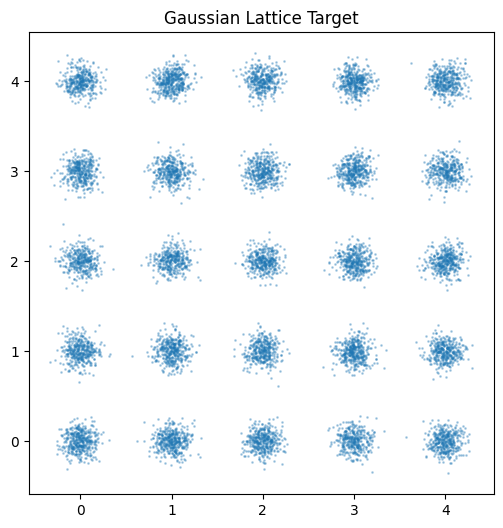

In [187]:
lattice_shape = (5, 5)
target = create_gaussian_lattice(lattice_shape, 1, 0.01, device=device)
target_samples = target.sample((10000,))
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(*pl(target_samples), s=1, alpha=0.3)
ax.set_title('Gaussian Lattice Target');

target_name = f'gaussian_lattice{lattice_shape}'

**Target 2**

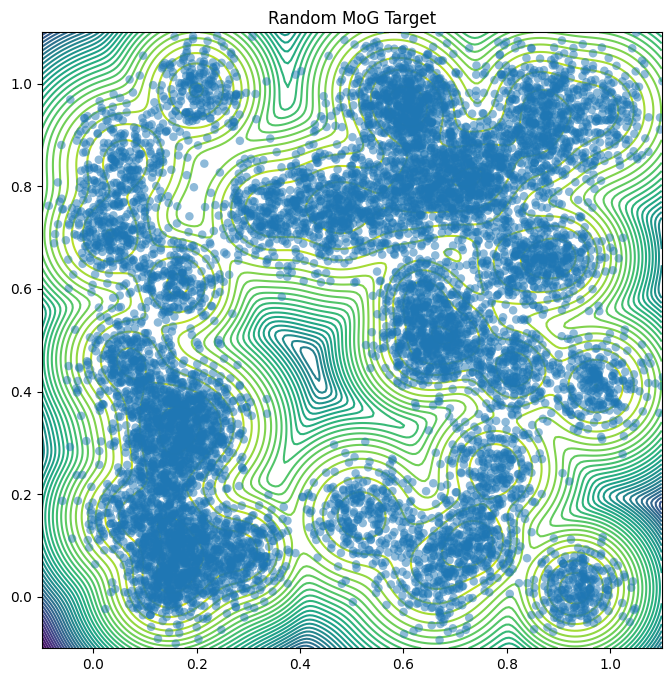

In [3]:
mean_lim = np.array([0, 1])
plot_lim = (-0.1, 1.1)
N = 10_000
d = 200
seed = 46
n_components = 40
target = create_random_gaussian_mixture(dim=2, n_components=n_components, mean_lim=mean_lim, variance_lim=(0.0015, 0.003), device=device, seed=seed)
target_sample = target.sample((N,))
x = torch.linspace(*plot_lim, d)
y = torch.linspace(*plot_lim, d)
X, Y = torch.meshgrid(x, y, indexing='ij')
points = torch.vstack((X.ravel(), Y.ravel()))
Z = target.log_prob(points.T.to(device)).reshape(d, d)

fig, ax = plt.subplots(figsize=(8, 8))
ax.contour(to_numpy(X), to_numpy(Y), to_numpy(Z), levels=40);
ax.scatter(*pl(target_sample), zorder=4, alpha=0.5, s=150, edgecolors='none', marker='.')
ax.set_xlim(*plot_lim)
ax.set_ylim(*plot_lim)
ax.set_title('Random MoG Target');

target_name = f'mog{n_components}_seed{seed}'

In [5]:
model = VAE(
    data_dim=2,
    hidden_dims=(32, 32, 32),
    latent_dim=2,
    device=device
)
model_filename = f'models/{target_name}_vae'

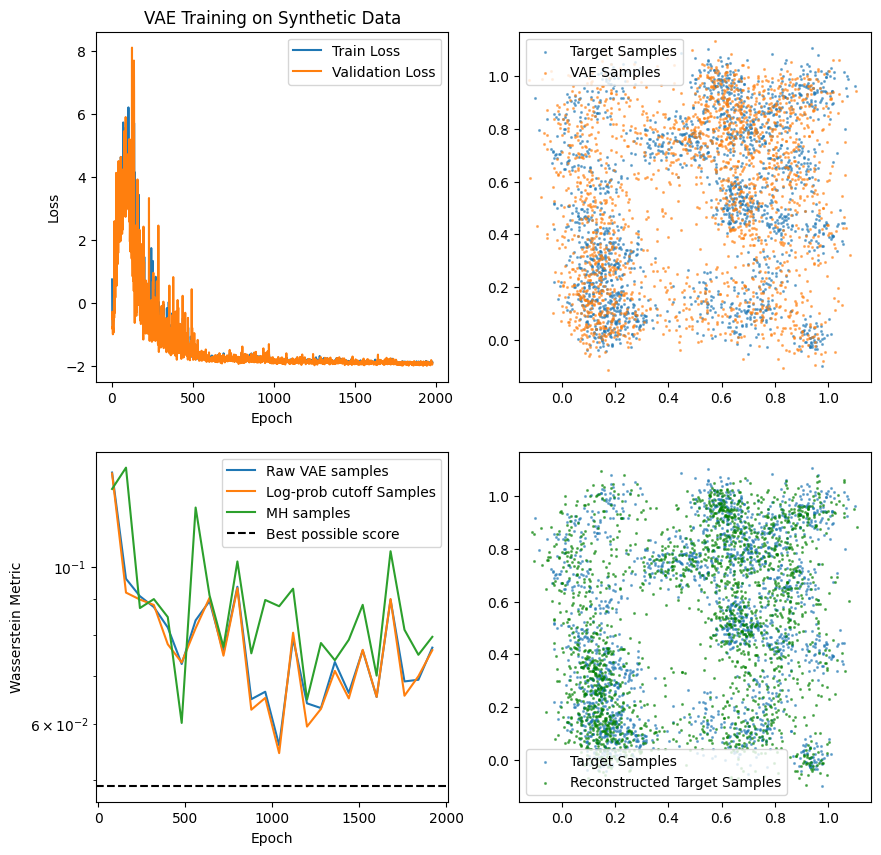

Epoch 1980
	Train loss: -1.8793
	Validation loss: -1.8885
	Learning rate: 0.000625


In [203]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=200, threshold=1e-3)
model.fit_distribution(
    target, 16_384, optimizer,
    scheduler=scheduler, max_epochs=2000,
    no_kl_penalty_epochs=90,
    kl_annealing_epochs=500, batch_size=2_048,
    distribution_metric=WassersteinMetric()
)

In [204]:
model.save_knowledge(model_filename)

In [10]:
model.load_knowledge(model_filename)
model.set_std_factor(1)

In [11]:
L = 64
beta = 1
model_log_prob_estimator = lambda x : model.iw_log_marginal_estimate(x, L=L, beta=beta, batch_L=32)

CPU times: total: 2min 6s
Wall time: 24.4 s


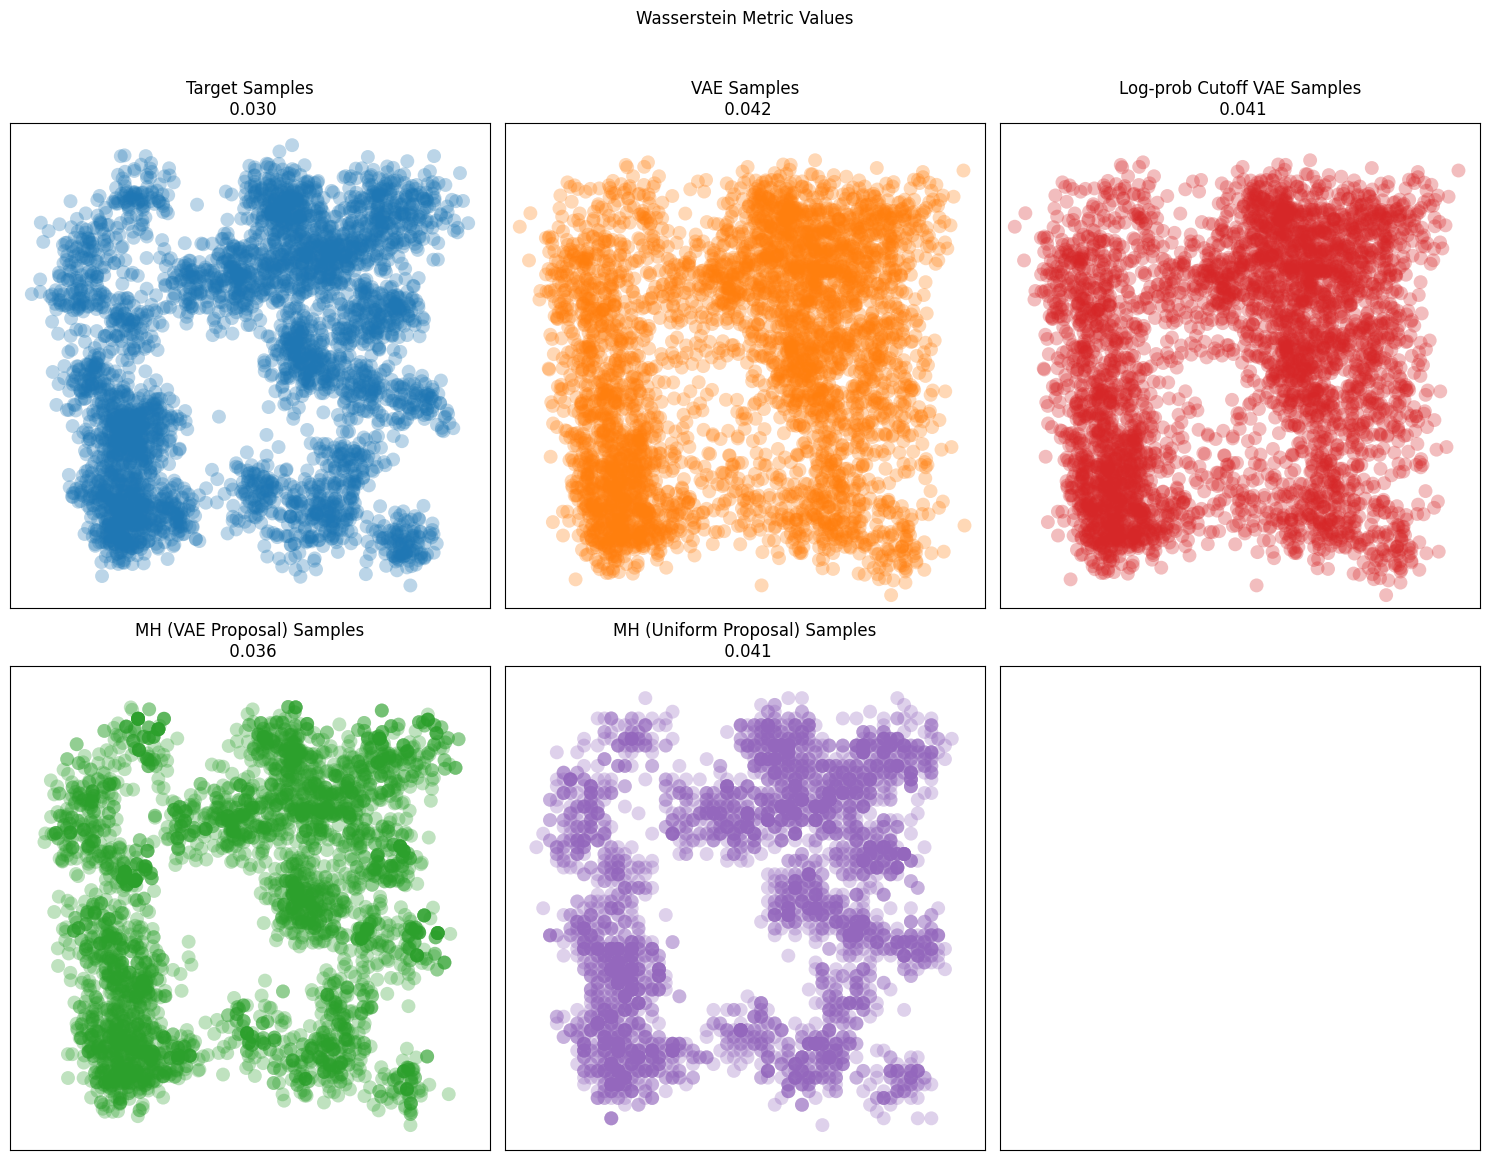

In [35]:
%%time

def plot_samples():
    #metric = SlicedDistributionMetric(WassersteinMetric(), 6)
    metric = WassersteinMetric()
    N = 4096
    q = 0.0
    n_runs=2
    
    target_samples = target.sample((N,))
    target_quantile = target.log_prob(target_samples).quantile(q)
    model_samples = model.sample((N,))
    cut_acc_rate, cut_samples = log_prob_cutoff_filter(target, model_samples, target_quantile, return_indicies=False)
    mh_acc_rate, mh_samples = metropolis_hastings_filter(target, cut_samples, model_log_prob_estimator, n_estimates=10, return_indicies=False)

    plot_lim = (-0.1, 1.1)
    x = torch.linspace(*plot_lim, int(N ** 0.5))
    y = torch.linspace(*plot_lim, int(N ** 0.5))
    X, Y = torch.meshgrid(x, y, indexing='ij')
    uniform_samples = torch.vstack((X.ravel(), Y.ravel())).T[torch.randperm(N)].to(device)
    mh_uni_acc_rate, mh_uni_samples = metropolis_hastings_filter(target, uniform_samples, lambda x: torch.ones(x.shape[0]), return_indicies=False)

    def scatter(ax_num, samples, *args, **kwargs):
        axs[ax_num].scatter(*pl(samples), s=400, alpha=0.3, edgecolors='none', marker='.', *args, **kwargs)
    fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 11))
    axs = axs.flatten()
    scatter(0, target_samples)
    axs[0].set_title(f'Target Samples\n{metric(target_samples, target.sample((N,))): 0.3f}')
    scatter(1, model_samples, color='tab:orange')
    axs[1].set_title(f'VAE Samples\n{metric(target_samples, model_samples): 0.3f}')
    scatter(2, cut_samples, color='tab:red')
    axs[2].set_title(f'Log-prob Cutoff VAE Samples\n{metric(target_samples, cut_samples): 0.3f}')
    scatter(3, mh_samples, color='tab:green')
    axs[3].set_title(f'MH (VAE Proposal) Samples\n{metric(target_samples, mh_samples): 0.3f}')
    scatter(4, mh_uni_samples, color='tab:purple')
    axs[4].set_title(f'MH (Uniform Proposal) Samples\n{metric(target_samples, mh_uni_samples): 0.3f}')
    for ax in axs:
        #ax.axis('equal')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(axs[0].get_xlim())
        ax.set_ylim(axs[0].get_ylim())
    plt.tight_layout()
    fig.suptitle(f'{metric.name()} Values', y=1.05)

plot_samples()

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [04:04<00:00, 12.22s/it]


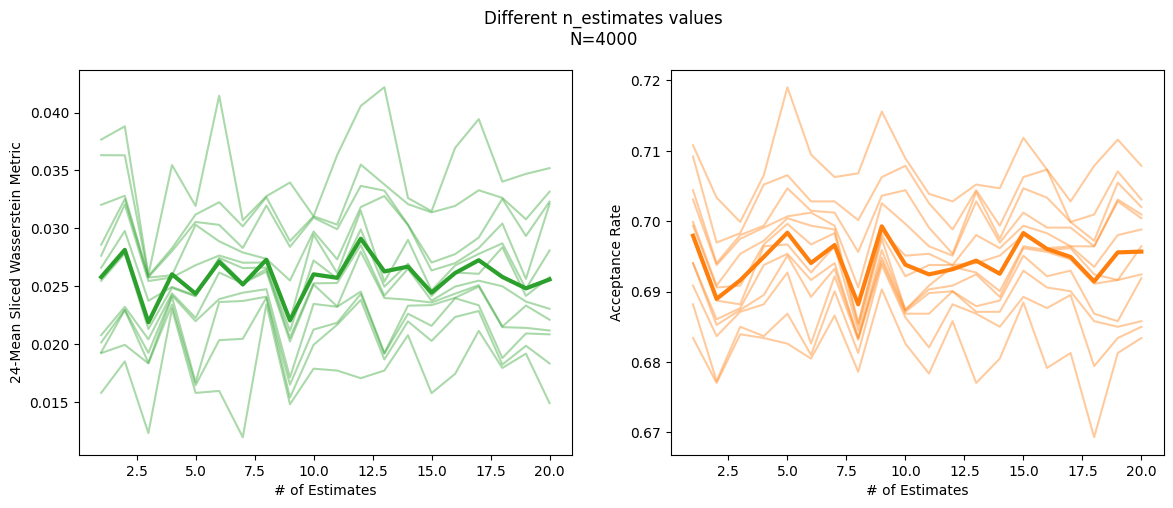

In [223]:
def find_optimal_n_estimates():
    metric = SlicedDistributionMetric(WassersteinMetric1d(), 24)
    # metric = WassersteinMetric()
    N = 4000
    q = 0.0
    n_estimates_options = np.arange(1, 21)
    n_runs = 12
    
    target_samples = target.sample((N,))
    model_samples = model.sample((N,))
    target_quantile = target.log_prob(target_samples).quantile(q)
    cut_acc_rate, cut_samples = log_prob_cutoff_filter(target, model_samples, target_quantile, return_indicies=False)

    mh_metrics = []
    mh_acc_rates = []
    for n_estimates in tqdm(n_estimates_options):
        mh_metrics.append([])
        mh_acc_rates.append([])
        for i in range(n_runs):
            mh_acc_rate, mh_samples = metropolis_hastings_filter(target, cut_samples, model_log_prob_estimator, n_estimates=n_estimates, return_indicies=False)
            mh_metrics[-1].append(metric(target_samples, mh_samples).item())
            mh_acc_rates[-1].append(mh_acc_rate)

    def plot(ax_num, values, *args, **kwargs):
        values = np.array(values)
        values.sort()
        mean_values = values.mean(axis=-1)
        for i in range(values.shape[1]):
            axs[ax_num].plot(n_estimates_options, values[:, i], alpha=0.4, *args, **kwargs)
        axs[ax_num].plot(n_estimates_options, mean_values, linewidth=3, *args, **kwargs)
    fig, axs = plt.subplots(ncols=2, figsize=(14, 5))
    plot(0, mh_metrics, color='tab:green')
    # axs[0].set_title()
    axs[0].set_xlabel('# of Estimates')
    axs[0].set_ylabel(f'{metric.name()}')
    plot(1, mh_acc_rates, color='tab:orange')
    axs[1].set_xlabel('# of Estimates')
    axs[1].set_ylabel(f'Acceptance Rate')
    #plt.tight_layout()
    fig.suptitle(f'Different n_estimates values\nN={N}', y=1)

find_optimal_n_estimates()

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [04:11<00:00, 11.96s/it]


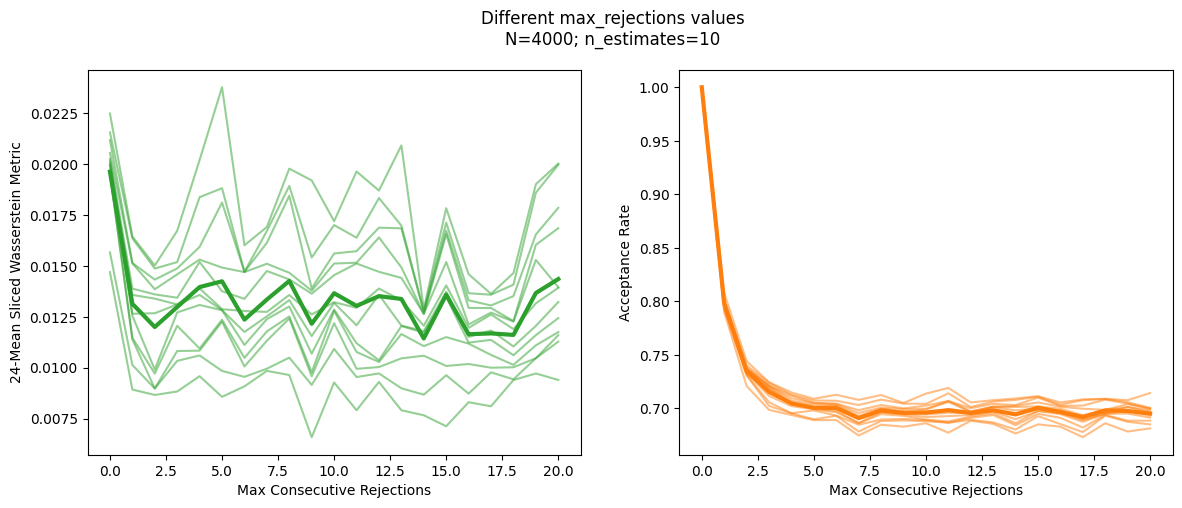

In [225]:
def find_optimal_max_rejections():
    metric = SlicedDistributionMetric(WassersteinMetric1d(), 24)
    #metric = WassersteinMetric()
    N = 4000
    q = 0.0
    max_rejections_options = np.arange(0, 21)
    n_runs = 12
    n_estimates = 10
    
    target_samples = target.sample((N,))
    model_samples = model.sample((N,))
    target_quantile = target.log_prob(target_samples).quantile(q)
    cut_acc_rate, cut_samples = log_prob_cutoff_filter(target, model_samples, target_quantile, return_indicies=False)

    mh_metrics = []
    mh_acc_rates = []
    for max_rejections in tqdm(max_rejections_options):
        mh_metrics.append([])
        mh_acc_rates.append([])
        for i in range(n_runs):
            mh_acc_rate, mh_samples = metropolis_hastings_filter(target, cut_samples, model_log_prob_estimator, n_estimates=10, max_rejections=max_rejections, return_indicies=False)
            mh_metrics[-1].append(metric(target_samples, mh_samples).item())
            mh_acc_rates[-1].append(mh_acc_rate)

    def plot(ax_num, values, *args, **kwargs):
        values = np.array(values)
        mean_values = values.mean(axis=-1)
        values.sort()
        for i in range(values.shape[1]):
            axs[ax_num].plot(max_rejections_options, values[:, i], alpha=0.5, *args, **kwargs)
        axs[ax_num].plot(max_rejections_options, mean_values, linewidth=3, *args, **kwargs)
    fig, axs = plt.subplots(ncols=2, figsize=(14, 5))
    plot(0, mh_metrics, color='tab:green')
    # axs[0].set_title()
    axs[0].set_xlabel('Max Consecutive Rejections')
    axs[0].set_ylabel(f'{metric.name()}')
    plot(1, mh_acc_rates, color='tab:orange')
    axs[1].set_xlabel('Max Consecutive Rejections')
    axs[1].set_ylabel(f'Acceptance Rate')
    #plt.tight_layout()
    fig.suptitle(f'Different max_rejections values\nN={N}; n_estimates={n_estimates}', y=1)

find_optimal_max_rejections()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:28<00:00, 32.84s/it]


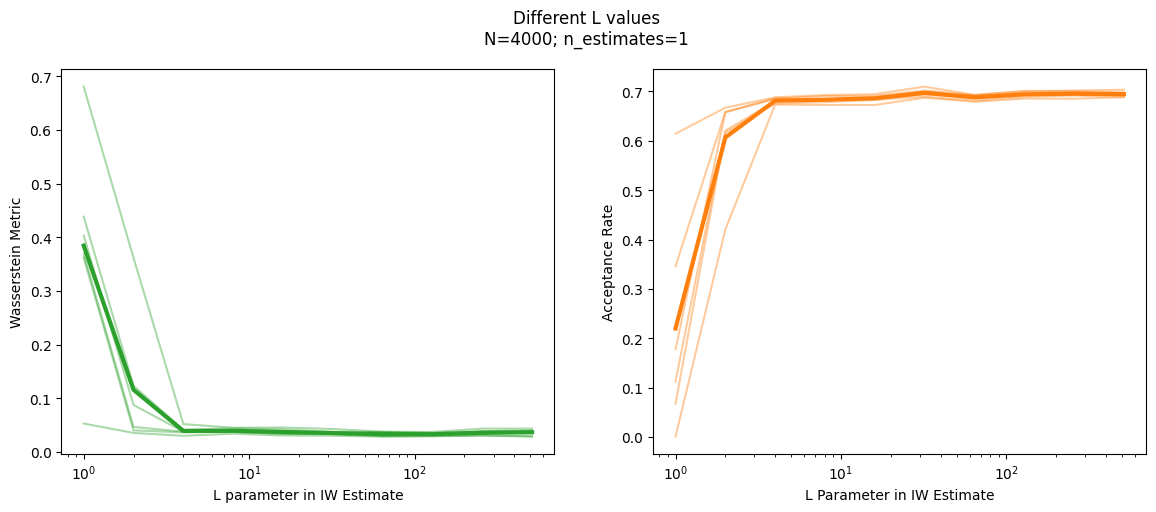

In [34]:
def find_optimal_L():
    # metric = SlicedDistributionMetric(WassersteinMetric1d(), 24)
    metric = WassersteinMetric()
    N = 4000
    q = 0.0
    L_options = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
    n_runs = 6
    n_estimates = 1
    
    target_samples = target.sample((N,))
    model_samples = model.sample((N,))
    target_quantile = target.log_prob(target_samples).quantile(q)
    cut_acc_rate, cut_samples = log_prob_cutoff_filter(target, model_samples, target_quantile, return_indicies=False)

    mh_metrics = []
    mh_acc_rates = []
    for L in tqdm(L_options):
        mh_metrics.append([])
        mh_acc_rates.append([])
        model_log_prob_estimator = lambda x : model.iw_log_marginal_estimate(x, L=L, beta=beta, batch_L=32)
        for i in range(n_runs):
            mh_acc_rate, mh_samples = metropolis_hastings_filter(target, cut_samples, model_log_prob_estimator, n_estimates=n_estimates, return_indicies=False)
            mh_metrics[-1].append(metric(target_samples, mh_samples).item())
            mh_acc_rates[-1].append(mh_acc_rate)

    def plot(ax_num, x, ys, *args, **kwargs):
        ys = np.array(ys)
        ys.sort()
        mean_ys = ys.mean(axis=-1)
        for i in range(ys.shape[1]):
            axs[ax_num].plot(x, ys[:, i], alpha=0.4, *args, **kwargs)
        axs[ax_num].plot(x, mean_ys, linewidth=3, *args, **kwargs)
    
    fig, axs = plt.subplots(ncols=2, figsize=(14, 5))
    plot(0, L_options, mh_metrics, color='tab:green')
    # axs[0].set_title()
    axs[0].set_xlabel('L parameter in IW Estimate')
    axs[0].set_ylabel(f'{metric.name()}')
    plot(1, L_options, mh_acc_rates, color='tab:orange')
    axs[1].set_xlabel('L Parameter in IW Estimate')
    axs[1].set_ylabel(f'Acceptance Rate')
    for ax in axs:
        ax.set_xscale('log')
    #plt.tight_layout()
    fig.suptitle(f'Different L values\nN={N}; n_estimates={n_estimates}', y=1)

find_optimal_L()